In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def entropy(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

def information_gain(y, x):
    parent_entropy = entropy(y)
    info_a = 0
    for value in set(x):
        partition_indices = x[x == value].index
        partition_entropy = entropy(y[partition_indices])
        info_a += len(partition_indices) / len(x) * partition_entropy
    gain_a = parent_entropy - info_a
    return gain_a

def decision_tree(X_train, y_train, max_depth, current_depth=0):
    if len(set(y_train)) == 1 or current_depth == max_depth or len(X_train.columns) == 0:
        class_counts = Counter(y_train)
        if class_counts:
            majority_class = class_counts.most_common(1)[0][0]
            return {"class_label": majority_class}
        else:
            # If class_counts is empty, return None or handle it appropriately
            return None
    
    gains = {}
    for attr in X_train.columns:
        if X_train[attr].dtype == 'object':
            gains[attr] = information_gain(y_train, X_train[attr])
        else:
            # For numerical attributes
            attr_mean = X_train[attr].mean()
            partition_indices_left = X_train[X_train[attr] <= attr_mean].index
            partition_indices_right = X_train[X_train[attr] > attr_mean].index
            partition_entropy_left = entropy(y_train[partition_indices_left])
            partition_entropy_right = entropy(y_train[partition_indices_right])
            weight_left = len(partition_indices_left) / len(X_train)
            weight_right = len(partition_indices_right) / len(X_train)
            info_a = weight_left * partition_entropy_left + weight_right * partition_entropy_right
            gains[attr] = entropy(y_train) - info_a
    
    best_attr = max(gains, key=gains.get)
    node = {"attribute": best_attr, "leaf": {}}
    
    if X_train[best_attr].dtype == 'object':
        unique_values = X_train[best_attr].unique()
        for value in unique_values:
            partition_indices = X_train[X_train[best_attr] == value].index
            node["leaf"][value] = decision_tree(X_train.loc[partition_indices], y_train.loc[partition_indices], max_depth, current_depth + 1)
    else:
        attr_mean = X_train[best_attr].mean()
        partition_indices_left = X_train[X_train[best_attr] <= attr_mean].index
        partition_indices_right = X_train[X_train[best_attr] > attr_mean].index
        node["split_value"] = attr_mean
        node["left"] = decision_tree(X_train.loc[partition_indices_left], y_train.loc[partition_indices_left], max_depth, current_depth + 1)
        node["right"] = decision_tree(X_train.loc[partition_indices_right], y_train.loc[partition_indices_right], max_depth, current_depth + 1)
    
    return node

def classify_random_forest(trees, subsampled_attributes, X_test):
    class_labels = []
    for _, test_row in X_test.iterrows():  # Iterate over the rows
        tree_votes = []
        for tree, sub_attributes in zip(trees, subsampled_attributes):
            test_features = test_row[sub_attributes]  # Use sub_attributes directly
            predicted_label = classify(tree, test_features)
            tree_votes.append(predicted_label[0])  # Append predicted label
        class_labels.append(max(set(tree_votes), key=tree_votes.count))  # Perform majority voting
    return class_labels


def classify(tree, features):
    class_labels = []
    if isinstance(features, pd.Series):  # Check if features is a Series
        node = tree
        while "class_label" not in node:
            if features[node['attribute']] <= node['split_value']:
                node = node['left']
            else:
                node = node['right']
        class_labels.append(node['class_label'])
    else:  # If features is a DataFrame
        for _, feature in features.iterrows():
            node = tree
            while "class_label" not in node:
                if feature[node['attribute']] <= node['split_value']:
                    node = node['left']
                else:
                    node = node['right']
            class_labels.append(node['class_label'])
    return class_labels

def bootstrap_sampling(X, y):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    return X.iloc[indices], y.iloc[indices]

def fit_random_forest(num_trees, max_depth, example_subsample_rate, attr_subsample_rate, X_train, y_train):
    trees = []
    subsampled_attributes = []

    for i in range(num_trees):
        # Bootstrap sampling to create a bootstrapped dataset
        bootstrapped_X, bootstrapped_y = bootstrap_sampling(X_train, y_train)

        # Subsample attributes
        subsampled_attr_indexes = np.random.choice(range(X_train.shape[1]), int(X_train.shape[1] * attr_subsample_rate), replace=False)
        subsampled_attributes.append(subsampled_attr_indexes.tolist())
        subsampled_X = bootstrapped_X.iloc[:, subsampled_attr_indexes]

        # Build decision tree using the bootstrapped and subsampled dataset
        tree = decision_tree(subsampled_X, bootstrapped_y, max_depth)
        trees.append(tree)

    return trees, subsampled_attributes

def confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_label in enumerate(classes):
        for j, pred_label in enumerate(classes):
            conf_matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))

    return conf_matrix

def calculate_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    accuracy = np.sum(TP) / np.sum(conf_matrix)
    
    precision = np.where(TP + FP == 0, 0, TP / (TP + FP))
    recall = np.where(TP + FN == 0, 0, TP / (TP + FN))
    
    # Handle division by zero or empty slices for F1-score
    f1_score = np.zeros_like(precision)
    non_zero_denominator = (precision + recall) != 0
    f1_score[non_zero_denominator] = 2 * (precision[non_zero_denominator] * recall[non_zero_denominator]) / (precision[non_zero_denominator] + recall[non_zero_denominator])
    
    return accuracy, precision, recall, f1_score

def stratified_cross_validation(X, y, n_folds, num_trees, max_depth, example_subsample_rate, attr_subsample_rate):
    fold_size = len(X) // n_folds
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    conf_matrices = []

    for i in range(n_folds):
        start = i * fold_size
        end = (i + 1) * fold_size

        X_train_fold = pd.concat([X[:start], X[end:]])
        y_train_fold = pd.concat([y[:start], y[end:]])

        X_validation_fold = X[start:end]
        y_validation_fold = y[start:end]
        
        trees, subsampled_attributes = fit_random_forest(num_trees, max_depth, example_subsample_rate, attr_subsample_rate, X_train_fold, y_train_fold)
        predictions = classify_random_forest(trees, subsampled_attributes, X_validation_fold)
        
        # Convert y_validation_fold to list
        y_validation_fold_list = y_validation_fold.tolist()
        
        # Calculate metrics
        conf_matrix = confusion_matrix(y_validation_fold_list, predictions)
        acc, prec, rec, f1 = calculate_metrics(conf_matrix)
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        
        conf_matrices.append(conf_matrix)

    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean([np.mean(precision, axis=0) for precision in precisions], axis=0)
    mean_recall = np.mean([np.mean(recall, axis=0) for recall in recalls], axis=0)
    mean_f1_score = np.nanmean([np.nanmean(f1_score, axis=0) for f1_score in f1_scores], axis=0)

    return mean_accuracy, mean_precision, mean_recall, mean_f1_score

if __name__ == "__main__":
    # Read the dataset
    df_cancer = pd.read_csv("/Users/noshitha/Downloads/hw3/datasets/hw3_cancer.csv", delimiter="\t")

    # Shuffle the dataset
    df_cancer_shuffle = shuffle(df_cancer)

    # Split the dataset into features and target variable
    X = df_cancer_shuffle.iloc[:, :-1]
    y = df_cancer_shuffle.iloc[:, -1]
    
    n_trees_list = [1, 5, 10, 20, 30, 40, 50]
    #n_trees_list = [1]
    n_folds = 10
    max_depth = 3
    example_subsample_rate = 0.5
    attr_subsample_rate = 0.5
    
    accuracy  = []
    precision = []
    recall    = []
    f1_score  = []
    
    for num_trees in n_trees_list:
        print("num_trees: ",num_trees)
        accuracies, precisions, recalls, f1_scores = stratified_cross_validation(X, y, n_folds, num_trees, max_depth, example_subsample_rate, attr_subsample_rate)
        print("Accuracies:", accuracies)
        print("Precisions:", precisions)
        print("Recalls:", recalls)
        print("F1-scores:", f1_scores)
        accuracy.append(accuracies)
        precision.append(precisions)
        recall.append(recalls)
        f1_score.append(f1_scores)

num_trees:  1
Accuracies: 0.9057971014492754
Precisions: 0.9014908677438755
Recalls: 0.8918340303024394
F1-scores: 0.8930110762071587
num_trees:  5
Accuracies: 0.9507246376811593
Precisions: 0.9453947768728043
Recalls: 0.9432055364719467
F1-scores: 0.9438486395580892
num_trees:  10
Accuracies: 0.9565217391304348
Precisions: 0.9493075162996293
Recalls: 0.9505819646913443
F1-scores: 0.9495454845317586
num_trees:  20
Accuracies: 0.9565217391304348
Precisions: 0.9510272206373171
Recalls: 0.9493544484089715
F1-scores: 0.9495336234247265
num_trees:  30
Accuracies: 0.9579710144927537
Precisions: 0.9485389832804675
Recalls: 0.9543511357532817
F1-scores: 0.9506672318814531
num_trees:  40
Accuracies: 0.9608695652173914
Precisions: 0.9539398108213655
Recalls: 0.957753702158835
F1-scores: 0.9553742096276855
num_trees:  50
Accuracies: 0.9579710144927537
Precisions: 0.9523169524952666
Recalls: 0.9538559236328978
F1-scores: 0.9520972052305421


### Accuracy

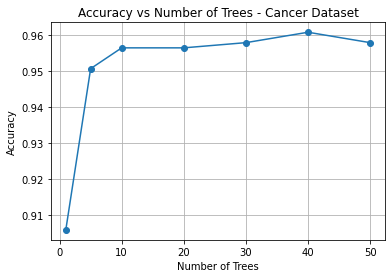

In [2]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, accuracy, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees - Cancer Dataset')
plt.grid(True)
plt.show()

### Precision

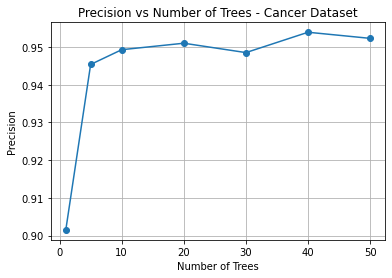

In [3]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.title('Precision vs Number of Trees - Cancer Dataset')
plt.grid(True)
plt.show()

### Recall

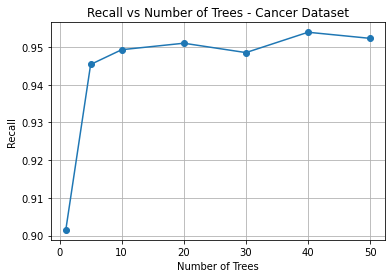

In [4]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')
plt.title('Recall vs Number of Trees - Cancer Dataset')
plt.grid(True)
plt.show()

### F1_score

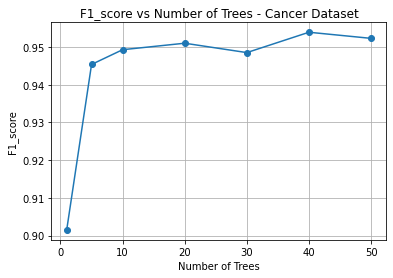

In [5]:
import matplotlib.pyplot as plt

plt.plot(n_trees_list, precision, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('F1_score')
plt.title('F1_score vs Number of Trees - Cancer Dataset')
plt.grid(True)
plt.show()